In [1]:
%matplotlib inline
import numpy as np
from scipy.optimize import minimize
from qiskit import *

<h1 align="center">
Quantum simulation of a many-body system
</h1>

**The problem:** Simulating quantum systems with several interacting bodies on a classical computer is very difficult.

<img src="manybody.png" alt="drawing" width="500"/>

**The solution:** One of the important things to know about this system is its ground energy. For such very large systems, this task becomes more difficult for a conventional computer, and here where the quantum computer is advantageous.

Quantum computer uses the variational quantum eigensolver (VQE); a hybrid classical-quantum algorithm that variationally determines the ground state energy of a Hamiltonian using the variational principle:
$\langle \psi | H | \psi \rangle \geq E_i \rightarrow$ the expectation value of a Hamiltonian will always be greater than or equal to the energy of the ground state of this system.

&#10170; **For the sake of simplicity, let us focus on a system of two spins, and study the interaction between them:**

<img src="twobody.png" alt="drawing" width="300"/>



Let us find out the matrix representation of the two $spin\;1/2$ particles Hamiltonian that describe their interaction, an example of this system is the hydrogen atom, which has a $spin\;1/2 $proton in the nucleus and a $spin\;1/2$ electron located around.

Along the z-axis this system forms basis states which contains 4 states:

$$
|\uparrow \uparrow\rangle=|\uparrow\rangle_{1}|\uparrow\rangle_{2},\quad |\uparrow \downarrow\rangle=|\uparrow\rangle_{1}|\downarrow\rangle_{2},\quad |\downarrow \uparrow\rangle=|\downarrow\rangle_{1}|\uparrow\rangle_{2},\quad |\downarrow \downarrow\rangle=|\downarrow\rangle_{1}|\downarrow\rangle_{2}
$$

Where: $\quad |\quad\rangle_1$ : state for the particle 1 and $\quad |\quad\rangle_2$: state for the particle 2.

Some requirements:

$$
\begin{array}{l}
\checkmark \quad \hat{\vec{S}}=\hat{\vec{S}}_{x}+\hat{\vec{S}}_{y}+\hat{\vec{S}}_{z} \\
\checkmark \quad S_{+}=S_{x}+i S_{y}, \quad S_{-}=S_{x}-i S_{y} \\
\checkmark \quad S_{z}|\uparrow\rangle=+ \frac{\hbar}{2}|\uparrow\rangle,\;\; S_{z}|\downarrow\rangle=- \frac{\hbar}{2}|\downarrow\rangle ,\;\; S_{+}|\downarrow\rangle=\hbar|\uparrow\rangle, \;\; S_{-}|\uparrow\rangle=\hbar|\downarrow\rangle, \;\; S_{+}|\uparrow\rangle=0, \;\; S_{-}|\downarrow\rangle=0
\end{array}
$$

We define the Hamiltonian that describes this interaction as:

$$
\widehat{H}=\frac{2 A}{\hbar^{2}} \hat{\vec{S}}_{1} \cdot \hat{\vec{S}}_{2}
$$

Where he is proportional to the spin operator for the particles 1 and 2 $(\hat{\vec{S}}_{1} \text { and } \hat{\vec{S}}_{2} \; \text{respectively})$.
The $\frac{2 A}{\hbar^{2}}$ is a normalization factor, where $A$ is the measure of the strength of this interaction and has unit
energy.

Now let us go ahead and find the matrix representation relying on the requirements above:

$$
\widehat{H}=\frac{2 A}{\hbar^{2}} \hat{\vec{S}}_{1} \hat{\vec{S}}_{2}=\frac{2 A}{\hbar^{2}}\left(\hat{\vec{S}}_{1 x} \hat{\vec{S}}_{2 x}+\hat{\vec{S}}_{1 y} \hat{\vec{S}}_{2 y}+\hat{\vec{S}}_{12} \hat{\vec{S}}_{2 z}\right)=\frac{A}{\hbar^{2}}\left(\hat{\vec{S}}_{1+} \hat{\vec{S}}_{2-}+\hat{\vec{S}}_{1-} \hat{\vec{S}}_{2+}+2 \hat{\vec{S}}_{12} \hat{\vec{S}}_{2 z}\right)
$$

What are the components of this Hamiltonian matrix? To know that, we need to compute all the combinations of the system basis states $\{|\uparrow \uparrow\rangle, |\uparrow \downarrow\rangle, |\downarrow \uparrow\rangle, |\downarrow \downarrow\rangle\}$ of the following expression:

$$\langle\quad| \widehat{H} |\quad\rangle$$

By Using the requirements we can conclude the elements of this matrix; we end up with:

$$\widehat{H}=A\left(\begin{array}{cccc}
\frac{1}{2} & 0 & 0 & 0 \\
0 & -\frac{1}{2} & 1 & 0 \\
0 & 1 & -\frac{1}{2} & 0 \\
0 & 0 & 0 & \frac{1}{2}
\end{array}\right)$$

Looking at the matrix we can deduce easily two eigenvalues: $\frac{A}{2}$ and $\frac{A}{2}$.And the two other come from the middle $2\times2$ submatrix: $\frac{A}{2}$ and $-\frac{3 A}{2}$

The states of the eigenvalue $\frac{A}{2}$ form a spin 1 system, the state of the ground state energy $-\frac{3 A}{2},$ form a spin 0 system. The following figure makes it easy to understand:

<img src="spin_alignement.png" alt="drawing" width="500"/>

[Image source](https://chemistry.stackexchange.com/a/54259/85866)

* And know let's use VQE to find the groud state of the Hamiltonian:$H=\begin{pmatrix}
\frac{1}{2} & 0 &0  & 0 \\
0 & -\frac{1}{2} & 1 & 0 \\
0 & 1 & -\frac{1}{2} & 0 \\
0 & 0 & 0 & \frac{1}{2}
\end{pmatrix}.$

I'm ignoring the constante $A$ from the matrix to simplify the work, I will multiply the eigenvalue by it later.

## #VQE ON A **IDEAL** SIMULATOR
[See it also in the noisy case](https://github.com/walid-mk/VQE/blob/master/Task4/VQE.Noisy.Simulator.Code2.ipynb).

* Let first have the eigenvalues of $H$ and find the lowest one which corresponds to the lowest energy. We will use for this some ``` Numpy ``` tools:

In [2]:
H = np.mat("0.5 0 0 0; 0 -0.5 1 0; 0 1 -0.5 0; 0 0 0 0.5") #The Hamiltonian matrix
print("The eigenvalues of H :", np.linalg.eigvals(H))
print('The exact ground state energy is: ', np.linalg.eigvals(H)[1])

The eigenvalues of H : [ 0.5 -1.5  0.5  0.5]
The exact ground state energy is:  -1.5


* As we can see the lowest eigenvalue is $-\frac{3}{2}$.

## Variational Quantum Eingensolver (VQE):

### - Now let us find this value using VQE and see the accuracy of its result

* We need to be able to express the Hamiltonian matrix in a quantum circuit, so that the expectations values can be measured using the quantum computer.

* To do that we need to decompose $H$ into the sum of tensor products of Pauli operators, multiplied by some constant coefficients: $H = a \cdot II + b \cdot XX + c \cdot ZZ + d \cdot YY.$

    This equation leads to $4$ equations with $4$ variables, which can be written as $Ax=C$ :
$$
\begin{pmatrix}
1 & 0 & 1  & 0 \\
0 & 1 & 0 & -1 \\
1 & 0 & -1 & 0 \\
0 & 1 & 0 & 1
\end{pmatrix}.
\begin{pmatrix}
a \\
b \\
c \\
d
\end{pmatrix} = 
\begin{pmatrix}
1/2 \\
0 \\
-1/2 \\
1
\end{pmatrix}
$$

    We can use ```Numpy``` for this task to compute the coefficients $a$, $b$, $c$, and $d$ :

In [3]:
A = np.array([[1,0,1,0],[0,1,0,-1],[1,0,-1,0],[0,1,0,1]])
C = np.array([1/2,0,-1/2,1])
S = np.linalg.solve(A,C) # x = A^-1 * C
a, b, c, d = S[0], S[1], S[2], S[3]
print("a:", a,"\nb:", b, "\nc:", c, "\nd:", d)

a: 0.0 
b: 0.5 
c: 0.5 
d: 0.5


#### Therefore  $H = 0 \cdot II + 0.5 \cdot XX + 0.5 \cdot ZZ + 0.5 \cdot YY.$

And this is another way to compute those coefficients:
* Since the Pauli matrices form an orthogonal basis in the Hilbert space, and our $4\times4$ hermitian matrix is described in the same space, then: 
$$H = \sum_{i,j=1,x,y,z} a_{i,j} \left( \sigma_i \otimes \sigma_j \right),
$$
Therefore the coefficients are
$$
a_{i,j} = \frac{1}{4} Tr\left[\left( \sigma_i \otimes \sigma_j \right) H \right]
$$
the factor $\frac{1}{4}$ is due to normalization, [see the code for this method](https://michaelgoerz.net/notes/decomposing-two-qubit-hamiltonians-into-pauli-matrices.html). And for more detail [see this](https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis/8726#8726).

I'm going to convert $H$ to a dictionary for a purposeful reason:

In [4]:
H ={'II':a, 'XX':b, 'ZZ':c,'YY':d}
print(H)

{'II': 0.0, 'XX': 0.5, 'ZZ': 0.5, 'YY': 0.5}


### - The Ansatz:

* The variational method consists of calculating the expectation value of $H$, over multiple trial wavefunctions to get the right one which corresponds to the minimum energy $min_\theta\left\langle \psi \right| H \left| \psi \right\rangle = lowest\; energy$.

* So we initialize our circuit with a best guess, or ansatz: $$(I \otimes X).(C_{NOT}).(R_z(\theta) \otimes I).(H \otimes I) \left| 0 \right\rangle \otimes \left| 0 \right\rangle$$

In [5]:
# The ansatz initialization
def ansatz_init(circuit, parameter):
    q = circuit.qregs[0]
    circuit.h(q[0])
    circuit.rz(parameter, q[0])
    circuit.cx(q[0], q[1])
    circuit.x(q[1])
    return circuit

### - Transfer to the $Z\; basis$:
* Now to calculate the expectation value, we need to be very careful about the basis.
* The only physical measurement that a quantum computer can do, is in the Z basis {${\left| 0 \right\rangle; \left| 1 \right\rangle}$}. And as we can see, the Hamiltonian is decomposed into a linear combination of Pauli's matrices, as these form a basis for hermitian matrices. Hence, we have three kinds of measurement basis:
$$Z basis: {\left| 0 \right\rangle; \left| 1 \right\rangle},\qquad X basis: {\left| + \right\rangle; \left| - \right\rangle},\qquad Y basis: {\left| +i \right\rangle; \left| -i \right\rangle}.$$
Thus, we need to express the last two basis in the $Z\;basis$ :

 * $X\;basis$ in term of $Z\;basis$; we get the matrix: $H^{'} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}$.

 * $Y\;basis$ in term of $Z\;basis$; we get the matrix: $Y^{'} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
i & -i
\end{pmatrix}$.

<b> Those two matrices transfer from {${\left| 0 \right\rangle; \left| 1 \right\rangle}$} to {${\left| + \right\rangle; \left| - \right\rangle}$} and {${\left| +i \right\rangle; \left| -i \right\rangle}$} respectevly.
    
* Every quantum state $\left| \psi \right\rangle$ can be expressed in different sets of basis, so if we want it to be written in the {$\left| 0 \right\rangle; \left| 1 \right\rangle$} basis, to get the count of the measurement to calculate the expectations values, we process as follow:

 * We apply the inverse of $H^{'}$ to go from the {${\left| + \right\rangle; \left| - \right\rangle}$} basis to the {${\left| 0 \right\rangle; \left| 1 \right\rangle}$} basis; consequently, we get the matrix: $H_{gate} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & 1\\
1 & -1
\end{pmatrix}$. (It is the Hadamard gate)
 * We apply the inverse of $Y^{'}$ to go from the {${\left| +i \right\rangle; \left| -i \right\rangle}$} basis to the {${\left| 0 \right\rangle; \left| 1 \right\rangle}$} basis; then, we get the matrix: $Y_{gate} = \frac{1}{\sqrt{2}}\begin{pmatrix}
1 & -i\\
1 & i
\end{pmatrix}$.

In [6]:
# transfer to the Z basis measurement circuit
def z_measure_circ(parameter, measure):
    q = QuantumRegister(2)
    c = ClassicalRegister(2)
    circuit = QuantumCircuit(q, c)

    # implement the ansatz in the circuit
    circuit = ansatz_init(circuit, parameter)

    # measurement
    if measure == 'XX':
        circuit.barrier(q[0],q[1])
        circuit.u(np.pi/2, 0, np.pi, q[0])
        circuit.u(np.pi/2, 0, np.pi, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'ZZ':
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    elif measure == 'YY':
        circuit.barrier(q[0],q[1])
        circuit.u(np.pi/2, 0, np.pi/2, q[0])
        circuit.u(np.pi/2,0, np.pi/2, q[1])
        circuit.measure(q[0], c[0])
        circuit.measure(q[1], c[1])
    else:
         raise ValueError('Input should be "XX" or "YY" or "ZZ"')

    return circuit

* The counts result is returned in qiskit, in a form of a dictionary, so I will define a function ```get_from``` that returns the values in the dictionary. Also, it will be useful for the Hamiltonian dictionary created above.

In [7]:
# If key is missing than return 0 otherwise the corresponding value.
def get_from(d: dict, key: str):

    value = 0
    if key in d:
        value = d[key]
    return value

### - The expectation value:

* The expectation value in the case of two qubits, is calculated considering the computational basis (Z-Axis) as follow: eigenvalues of the Pauli's $Z$ matrix times the corresponding probabilities
$$\frac{1}{N}.(N_{00}\left\langle 00 \right| Z \otimes Z \left| 00 \right\rangle + N_{11}\left\langle 11 \right| Z \otimes Z \left| 11 \right\rangle + N_{10}\left\langle 10 \right| Z \otimes Z \left| 10 \right\rangle + N_{01}\left\langle 01 \right| Z \otimes Z \left| 01 \right\rangle)$$
In which: 
$$\left\langle 00 \right| Z \otimes Z \left| 00 \right\rangle = \left\langle 11 \right| Z \otimes Z \left| 11 \right\rangle = 1$$
and 
$$\left\langle 10 \right| Z \otimes Z \left| 10 \right\rangle = \left\langle 01 \right| Z \otimes Z \left| 01 \right\rangle = -1$$
therefore the expectation value become:
$$\frac{1}{N}.((N_{00} + N_{11}) - (N_{10} + N_{01}))$$
where $N$ is the number of shots, and $N_{00}$, $N_{11}$, $N_{10}$, $N_{01}$ are the number of time the state $\left| 00 \right\rangle$, $\left| 11 \right\rangle$, $\left| 10 \right\rangle$, $\left| 01 \right\rangle$ are measured respectively.

In [8]:
#calculate the expectation value for each Pauli's gate
def expec_value(parameter, measure):
    # measure in the right basis, then use the counts to compute the expectation value.
    if measure == 'II':
        return 1
    if measure == 'XX':
        circuit = z_measure_circ(parameter, 'XX')
    elif measure == 'ZZ':
        circuit = z_measure_circ(parameter, 'ZZ')
    elif measure == 'YY':
        circuit = z_measure_circ(parameter, 'YY')
    else:
        raise ValueError('Input should be "II" or "XX" or "ZZ" or "YY"')
    
    shots = 1000
    backend = BasicAer.get_backend('qasm_simulator')
    job = execute(circuit, backend, shots=shots)
    result = job.result()
    counts = result.get_counts()
    
    expectation_value = ((get_from(counts, '00')+get_from(counts, '11')) - 
                         (get_from(counts,'10')+get_from(counts, '01'))) / shots

    return expectation_value

* create a function ```sum_expec``` that sums up all the expectation value inside the one of the Hamiltonian, multiply them by their coefficients, and returns the final result.
$$\left\langle H \right\rangle = a \cdot \left\langle \psi \right| II \left| \psi \right\rangle + b \cdot \left\langle \psi \right| XX \left| \psi \right\rangle + c \cdot \left\langle \psi \right| ZZ \left| \psi \right\rangle + d \cdot \left\langle \psi \right| YY \left| \psi \right\rangle.$$

In [9]:
def sum_expec(parameter):
    if isinstance(parameter, np.ndarray): 
        parameter = parameter[0] 
    expec_value_II = get_from(H, 'II') * expec_value(parameter, 'II') #a*<II>
    expec_value_XX = get_from(H, 'XX') * expec_value(parameter, 'XX') #b*<XX>
    expec_value_ZZ = get_from(H, 'ZZ') * expec_value(parameter, 'ZZ') #c*<ZZ>
    expec_value_YY = get_from(H, 'YY') * expec_value(parameter, 'YY') #d*<YY>
    # summing the expectations results
    sum_result = expec_value_II + expec_value_XX + expec_value_ZZ + expec_value_YY
    
    return sum_result

### Using the optimizer:
* the ansatz we had initialize have one degree of freedom i.e. it depends in one parameter $\theta$ (rotation) on which she can vary, so the trials wavefunctions depend on $\theta$; $\left| \psi(\theta) \right\rangle$.

<b> So at the first time, we are going to count on an optimizer called ```minimize``` from ```scipy.optimize```, to search the best angle $\theta$, therefore the best wavefunction $\left| \psi(\theta) \right\rangle$, which minimize the expectation value: $min_\theta\left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle = lowest\; energy\;$.

In [11]:
from scipy.optimize import minimize_scalar
parameter = 1 #initialize an arbitrary angle

tol = 1e-3 #tolerance for optimization precision.
#Inject the sum_expec result inside the minimizer function
sum_expec_result = minimize(sum_expec, parameter, method="Powell", tol=tol)

print('The exact ground state energy is: {}'.format(-1.5))
print('The estimated ground state energy using VQE algorithm is: {}'.format(sum_expec_result.fun))
print("\nThe optimal parameter theta is : {} ".format(sum_expec_result.x))

The exact ground state energy is: -1.5
The estimated ground state energy using VQE algorithm is: -1.5

The optimal parameter theta is : 3.1454328877068733 


* As can be seen, the optimizer can ﬁnd the best angle $\theta = 3.1454328877068733 \approx \pi \;$ for the global minimum energy $ E = \left\langle \psi \right| H \left| \psi \right\rangle = -1.5$ (in arbitrary units) as expected.

### Using **```for```**  loop:
<b> Here, classical optimization is not necessary, since we have only one parameter to sweep over. Therefore it is obvious that we are going to loop over a set of values in the range $[0, 2\pi)$ :

In [13]:
angles = np.linspace(0.0, 2.0 * np.pi, 25) # an array of angles in [0,2pi)

lowest_array=[] #  empty regular list
for parameter in angles:
    lowest = sum_expec(parameter)
    lowest_array.append(lowest)
    low = np.array(lowest_array) # transformed to a numpy array

Some ```matplotlib``` functions to plot a nice graph :)

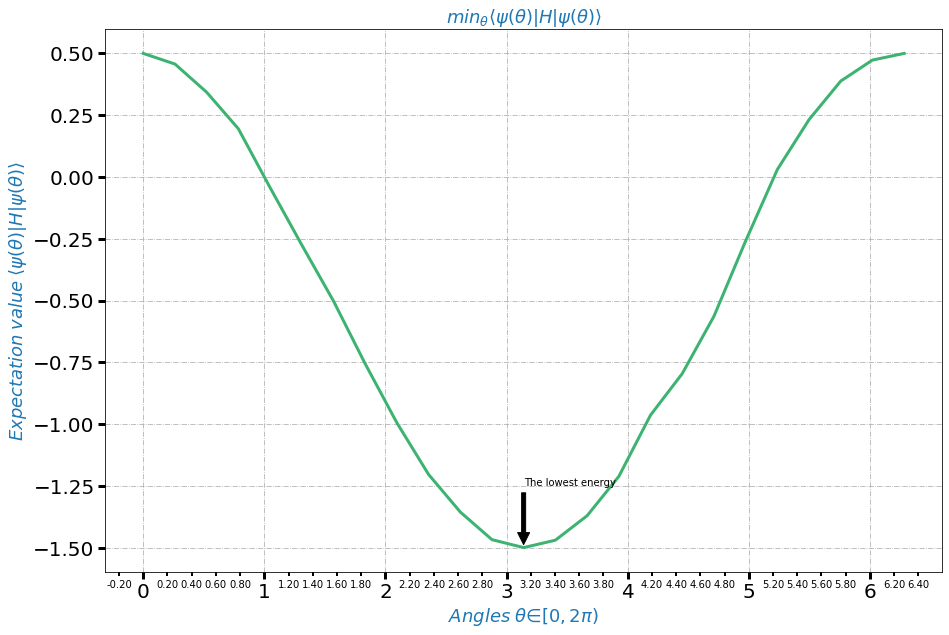

The intersection between the angle theta = pi and the constructed graph is the lowest energy:  -1.5


In [23]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (FormatStrFormatter, AutoMinorLocator, FuncFormatter)

fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot()
ax.plot(angles, low, linewidth=3, color='mediumseagreen')

ax.annotate('The lowest energy', xy=(3.141, -1.5), xytext=(3.141, -1.25),
             arrowprops=dict(facecolor='black', shrink=0.05),)
#make the minor graduation
def minor_tick(x, pos):
    if not x % 1.0:
        return ""
    return "%.2f" % x
ax.xaxis.set_minor_locator(AutoMinorLocator()) #plot the minor graduation
ax.xaxis.set_minor_formatter(FuncFormatter(minor_tick)) #plot the minor graduation numbers

ax.tick_params(which='both', width=2) #controle both graduation for x and y axis
ax.tick_params(which='major', length=7) #controle the major graduation; the number of grad
ax.tick_params(which='minor', length=4, color='black') #control the minor graduation the number of grad
ax.tick_params(labelcolor='black', labelsize=20, width=3) #controle the major graduation

plt.xlabel(r'$Angles \; \theta ∈ [0,2\pi)$', {'color': 'C0', 'fontsize': 18})
plt.ylabel(r'$Expectation \; value \; \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.title(r'$min_\theta \left\langle \psi(\theta) \right| H \left| \psi(\theta) \right\rangle$',
           {'color': 'C0', 'fontsize': 18})
plt.grid(linestyle='-.')
plt.show()
# Use the interpolation Numpy function, where it utilises the best angle given by the optimizer ≈𝜋, to see if
# it give us the right ground state in Y-axis in the graph below: (f(angle) = ?)
inter = np.interp( np.pi ,angles,low)
print('The intersection between the angle theta = pi and the constructed graph is the lowest energy: ',inter)

## &#10173; Final results: 

**Enumerating the expectation values for all angles, lead to the optimal angle $\theta=\pi$, therefore gives the lowest eigenstate $|\psi(\theta)\rangle$ (the right ansatz), found as follow:**

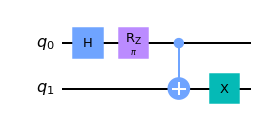

In [18]:
######## Ansatz Circuit ########
qc = QuantumCircuit(2)
qc.h(0)
qc.rz(np.pi,0)
qc.cx(0,1)
qc.x(1)
qc.draw('mpl')

In [24]:
from qiskit_textbook.tools import array_to_latex
######## Ansatz State-vector ########
backend2 = Aer.get_backend('statevector_simulator')
final_state = execute(qc,backend2).result().get_statevector()
array_to_latex(final_state, pretext=r"\\Statevector: \; |\psi(\theta)\rangle = ")

<IPython.core.display.Math object>

**The corresponding lowest energy is $\left\langle \psi(\pi)| H |\psi(\pi)\right\rangle = -1.5 \times A$, This energy match with an antisymmetric spin configuration, with a total angular momentum $𝑚_𝑠 = 0$, hence an antiparallel alignment between our two studied $spins\;1/2$, see below figure:**

<img src="groundstate.png" alt="drawing" width="300"/>



I searched the lowest energy for the same Hamiltonian, using the VQE in a noisy environment. Moreover, I used another code implementation  and take the same step I toke here to get the values, [see it in my github](https://github.com/walid-mk/VQE/blob/master/Task4/VQE.Noisy.Simulator.Code2.ipynb).

<h1 align="center">
References
</h1>

https://arxiv.org/abs/1304.3061

https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/variational_quantum_eigensolver.ipynb